# **About Dataset**

The provided dataset comprises synthesized financial transactions generated by **IBM (International Business Machines Corporation)**. It encapsulates interactions among individuals, businesses, and banks. Individuals interact with other individuals and businesses, while businesses engage with other businesses and individuals. These interactions encompass various forms, such as consumer purchases of goods and services, industrial supply orders, salary payments, loan repayments, among others.

Financial transactions predominantly occur through banks, where both the payer and recipient possess accounts, ranging from traditional checking accounts to credit cards and even cryptocurrencies like Bitcoin. Within this dataset model, a small subset of individuals and businesses is involved in criminal activities, including smuggling, illegal gambling, extortion, and similar behaviors. These criminals acquire funds from such illicit activities and subsequently attempt to conceal the illegal fund sources through a series of financial transactions.

This dataset models the complete money laundering cycle:
- Placement: Involves the introduction of funds from illegal sources, such as smuggling.
- Layering: Entails the mingling of illegal funds within the financial system.
- Integration: Signifies the expenditure of these illegal funds.

The aim is to employ data analysis methodologies to assist authorities in identifying and distinguishing potential instances of money laundering among the financial transactions recorded within this dataset.

# **Data Reading & Sampling**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

**Undersampling** is a technique used to address class imbalance in a dataset, commonly employed when the proportion between classes is significantly skewed. 

In the context of financial transactions where only a **small portion** is flagged as **money laundering**, undersampling involves reducing the abundance of the majority class (non-money laundering transactions) to match the quantity of the minority class (money laundering transactions). This process randomly selects and removes instances from the majority class until a balanced representation between both classes is achieved. By doing so, it ensures that the model is trained on a more proportionate dataset, mitigating the impact of class imbalance and improving the model's ability to accurately learn and predict across both classes.

In [9]:
chunk_size = 100000  
rus = RandomUnderSampler(random_state=42)
undersampled_data = pd.DataFrame()

for chunk in pd.read_csv(r'HI-Small_Trans.csv', chunksize=chunk_size):
   X_chunk = chunk.drop('Is Laundering', axis=1)
   y_chunk = chunk['Is Laundering']
    
   if len(y_chunk.unique()) > 1:
       X_rus, y_rus = rus.fit_resample(X_chunk, y_chunk)
       chunk_rus = pd.concat([X_rus, y_rus], axis=1)
       undersampled_data = pd.concat([undersampled_data, chunk_rus], ignore_index=True)     

The process of running this operation might **require a significant amount of time**, ranging from **5 to 10 minutes**, contingent upon the computational power of the GPU utilized. The duration can be influenced by the complexity of the task, the size of the dataset, and the efficiency of the hardware employed for processing. **Please be advised** that due to the substantial size of the dataset and the intricacy of the computational procedures involved, the **execution time might be prolonged**. The timeframe mentioned is an estimate and may vary based on the specific GPU specifications and the intricacies of the operations being performed.

In [10]:
df = undersampled_data

In [11]:
df.to_csv('HI-Small_Trans_Sampled.csv', index=False)

To **expedite the runtime**, utilizing undersampling to **create a new CSV file** with downsampled data is a sound approach. Undersampling involves reducing the size of the dataset by balancing the class distribution, especially in scenarios where the classes are imbalanced. By creating a new CSV file with the downsampled data, subsequent processes can simply read from this new CSV, thereby streamlining the operations and enhancing efficiency during runtime. This downsampling technique enables a more manageable dataset for analysis or model training, contributing to quicker processing times in subsequent tasks without compromising the integrity of the information.

In [12]:
df = pd.read_csv(r'HI-Small_Trans_Sampled.csv')

# **Data Understanding**

In [13]:
df.head(10)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:22,2845,8048442A0,2845,8048442A0,8474.24,US Dollar,8474.24,US Dollar,Reinvestment,0
1,2022/09/01 00:16,13145,803EA82D0,13145,803EA82D0,351811.03,US Dollar,351811.03,US Dollar,Reinvestment,0
2,2022/09/01 00:13,23537,808094A70,23537,808094A70,18.71,US Dollar,18.71,US Dollar,Reinvestment,0
3,2022/09/01 00:28,70,100428660,1601,8010D01B0,40228.29,US Dollar,40228.29,US Dollar,Cheque,0
4,2022/09/01 00:23,11318,800C4B390,11318,800C4B390,40068.30,US Dollar,40068.30,US Dollar,Reinvestment,0
5,2022/09/01 00:21,70,100428660,1124,800825340,389769.39,US Dollar,389769.39,US Dollar,Cheque,1
6,2022/09/01 00:03,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1
7,2022/09/01 00:01,70,100428660,15980,80B39E7B0,792.92,US Dollar,792.92,US Dollar,Credit Card,1
8,2022/09/01 00:03,70,100428660,113798,80DC756E0,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,1
9,2022/09/01 00:23,70,100428660,32375,80E480620,14288.83,US Dollar,14288.83,US Dollar,Cash,1


In [14]:
df.shape

(10354, 11)

In [15]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [16]:
df.columns = [col.replace(' ', '_').replace('.', '_').lower() for col in df.columns]
df.columns

Index(['timestamp', 'from_bank', 'account', 'to_bank', 'account_1',
       'amount_received', 'receiving_currency', 'amount_paid',
       'payment_currency', 'payment_format', 'is_laundering'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10354 entries, 0 to 10353
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           10354 non-null  object 
 1   from_bank           10354 non-null  int64  
 2   account             10354 non-null  object 
 3   to_bank             10354 non-null  int64  
 4   account_1           10354 non-null  object 
 5   amount_received     10354 non-null  float64
 6   receiving_currency  10354 non-null  object 
 7   amount_paid         10354 non-null  float64
 8   payment_currency    10354 non-null  object 
 9   payment_format      10354 non-null  object 
 10  is_laundering       10354 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 889.9+ KB


In [18]:
df.isnull().sum()

timestamp             0
from_bank             0
account               0
to_bank               0
account_1             0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64

That's great to know that the provided dataset is **already clean and free from NULL or missing values**. Having a clean dataset without missing values ensures that the data is complete and suitable for analysis or modeling tasks. It eliminates potential issues or biases that missing data might introduce into the analysis process. With a clean dataset, the subsequent analysis, feature engineering, and modeling procedures can be conducted more reliably and accurately, leading to more robust and dependable outcomes in data-driven tasks.

In [19]:
df['is_laundering'].value_counts()

is_laundering
0    5177
1    5177
Name: count, dtype: int64

The **undersampling** procedure has demonstrated its effectiveness by successfully **equalizing the proportions** of the 'is_laundering' class, resulting in an **equal distribution between the classes**. This balanced representation signifies that the undersampling technique effectively reduced the dataset's class imbalance, ensuring that both the positive and negative classes of 'is_laundering' are now equally represented. This balanced distribution is crucial in **mitigating biases** and **enhancing the model's ability to learn** and **make predictions accurately** across both classes, thereby improving the model's performance and reliability in detecting money laundering activities.

Displaying an example of money laundering occurrence: **[is_laundering] = 1**

In [20]:
df_laundering = df[df['is_laundering'] == 1]
df_laundering.head(10)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
5,2022/09/01 00:21,70,100428660,1124,800825340,389769.39,US Dollar,389769.39,US Dollar,Cheque,1
6,2022/09/01 00:03,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1
7,2022/09/01 00:01,70,100428660,15980,80B39E7B0,792.92,US Dollar,792.92,US Dollar,Credit Card,1
8,2022/09/01 00:03,70,100428660,113798,80DC756E0,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,1
9,2022/09/01 00:23,70,100428660,32375,80E480620,14288.83,US Dollar,14288.83,US Dollar,Cash,1
30,2022/09/01 00:23,231004,812EE86F0,21940,812EE89C0,3401.73,US Dollar,3401.73,US Dollar,ACH,1
31,2022/09/01 00:17,70,100428660,152980,8140702D0,6892.43,US Dollar,6892.43,US Dollar,Credit Card,1
32,2022/09/01 00:26,70,1004286A8,2591,800926A30,37145.30,Euro,37145.30,Euro,Cheque,1
33,2022/09/01 00:06,21174,800737690,12,80011F990,2848.96,Euro,2848.96,Euro,ACH,1
34,2022/09/01 04:33,21174,800737690,20,80020C5B0,8630.40,Euro,8630.40,Euro,ACH,1


Our initial hypothesis posited that money laundering occurs when there's a **disparity** between **[amount_received]** and **[amount_paid]**. However, subsequent filtering and analysis have **disproven our hypothesis**.

In [21]:
different_amounts = df[df['amount_received'] != df['amount_paid']]
different_amounts.head(100)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
112,2022/09/01 01:00,122946,8087EF3D0,122946,8087EF3D0,2724.39,US Dollar,2109.22,UK Pound,ACH,0
118,2022/09/01 00:18,314359,8127EA160,314359,8127EA160,9353.19,Saudi Riyal,183129.12,Rupee,ACH,0
137,2022/09/01 01:53,222363,80F701FA0,222363,80F701FA0,575.16,Euro,673.96,US Dollar,ACH,0
422,2022/09/01 05:33,1674,80042F4A0,1674,80042F4A0,24512.75,Australian Dollar,17350.48,US Dollar,ACH,0
455,2022/09/01 07:02,20,80681A170,20,80681A170,148.76,US Dollar,126.95,Euro,ACH,0
...,...,...,...,...,...,...,...,...,...,...,...
10006,2022/09/10 17:52,1267,803711710,1267,803711710,41.66,Euro,326.94,Yuan,ACH,0
10075,2022/09/10 15:13,131928,81080F2E0,131928,81080F2E0,22.38,US Dollar,149.92,Yuan,ACH,0
10105,2022/09/10 15:58,19705,80B16F6E0,19705,80B16F6E0,141.36,US Dollar,946.80,Yuan,ACH,0
10117,2022/09/10 14:54,33727,80C66DAE0,33727,80C66DAE0,2637.67,US Dollar,55768.52,Mexican Peso,ACH,0


As it turns out, the divergence in values between **[amount_received]** and **[amount_paid]** is attributed to the discrepancy in **[receiving_currency]** and **[payment_currency]**. Additionally, a majority of transactions utilize the **'ACH'** payment format.

In [22]:
same_currency = (df['amount_received'] != df['amount_paid']) & (df['receiving_currency'] == df['payment_currency'])
same_currency.value_counts()

False    10354
Name: count, dtype: int64

We also found out that there are no transactions that have different **[amount_received]** and **[amount_paid]** while the **[receiving_currency]** and **[payment_currency]** is the same.

In [23]:
df['payment_format'].value_counts()

payment_format
ACH             5177
Cheque          2309
Credit Card     1643
Cash             586
Reinvestment     247
Bitcoin          207
Wire             185
Name: count, dtype: int64

Based on the information obtained from the internet, here is an explanation regarding the **[payment_format]**:
1. **Reinvestment**: Indicates that the received funds from the transaction are reinvested into a specific investment entity or asset. This may involve reinvesting earnings or profits from existing investments.
2. **Cheque**: Involves the use of physical checks where an individual or an institution issues a check that can be cashed by the recipient by depositing it into a bank.
3. **Credit Card**: Allows buyers to make purchases using credit provided by the credit card issuer. Credit card users have a predetermined credit limit set by the card provider.
4. **ACH (Automated Clearing House)**: An electronic payment method enabling fund transfers between banks electronically, commonly used for routine payments such as monthly bill payments.
5. **Cash**: Payment made with physical currency, involving direct transaction using actual cash.
6. **Wire (Transfer)**: Electronic transfer of funds between banks, typically fast and secure, often used for large sums of money between different bank accounts.
7. **Bitcoin**: A type of cryptocurrency enabling users to conduct electronic peer-to-peer transactions without involving traditional financial institutions.

In [24]:
df_laundering['payment_format'].value_counts()

payment_format
ACH            4483
Cheque          324
Credit Card     206
Cash            108
Bitcoin          56
Name: count, dtype: int64

**Money laundering** tends to occur when utilizing the [payment_format] **ACH (Automated Clearing House)**: an electronic payment method enabling fund transfers between banks electronically, commonly used for routine payments such as monthly bill payments.

In [25]:
df['payment_currency'].value_counts()

payment_currency
US Dollar            3887
Euro                 2581
Saudi Riyal           467
Swiss Franc           425
Yuan                  391
Rupee                 362
Shekel                312
Yen                   295
UK Pound              293
Ruble                 285
Australian Dollar     255
Canadian Dollar       251
Bitcoin               207
Mexican Peso          201
Brazil Real           142
Name: count, dtype: int64

Based on the information obtained from the internet, here is an explanation regarding **[payment_currency]** and **[receiving_currency]**:
1. **US Dollar (USD)**: The official currency of the United States, commonly used as a global financial market reference currency.
2. **Euro (EUR)**: Currency used in most European Union member countries, introduced as a single currency to enhance economic integration in Europe.
3. **Yuan (CNY/RMB)**: The official currency of the People's Republic of China, also known as Renminbi (RMB), one of the most traded currencies globally.
4. **Ruble (RUB)**: The official currency of Russia, used within the Russian Federation.
5. **Yen (JPY)**: The official currency of Japan, frequently used in trade and one of the most traded currencies globally.
6. **Rupee (INR)**: The official currency of India, also used in several other countries such as Pakistan (PKR), Sri Lanka (LKR), and Nepal (NPR).
7. **UK Pound (GBP)**: The official currency of the United Kingdom (England), often referred to as Pound Sterling.
8. **Bitcoin (BTC)**: A cryptocurrency utilizing blockchain technology, traded on various cryptocurrency exchanges.
9. **Canadian Dollar (CAD)**: The official currency of Canada.
10. **Australian Dollar (AUD)**: The official currency of Australia, also used in some other territories like Cocos Islands, Christmas Island, and Norfolk Island.
11. **Mexican Peso (MXN)**: The official currency of Mexico.
12. **Brazil Real (BRL)**: The official currency of Brazil.
13. **Swiss Franc (CHF)**: The official currency of Switzerland.
14. **Shekel (ILS)**: The official currency of Israel.
15. **Saudi Riyal (SAR)**: The official currency of Saudi Arabia.

In [26]:
df_laundering['payment_currency'].value_counts()

payment_currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

**Money laundering** tends to occur when utilizing [payment_currency] **US Dollar**.

In [27]:
df['receiving_currency'].value_counts()

receiving_currency
US Dollar            3877
Euro                 2583
Saudi Riyal           469
Swiss Franc           429
Yuan                  384
Rupee                 360
Shekel                317
Yen                   295
UK Pound              292
Ruble                 288
Australian Dollar     259
Canadian Dollar       251
Bitcoin               208
Mexican Peso          199
Brazil Real           143
Name: count, dtype: int64

In [28]:
df_laundering['receiving_currency'].value_counts()

receiving_currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

The same trend is observed in [receiving_currency], where **Money laundering** tends to occur when using **US Dollar**.

# **Splitting the Data (Train & Test)**

The separation of datasets before engaging in exploratory data analysis and feature engineering tasks, such as encoding variables or normalization, stands as a **critical step** in the development of machine learning models. This process facilitates the division of information between data used for model training (training set) and data employed to test the model (test set), **mitigating the risk of data leakage** that might lead to **biased evaluations** or **overfitting**.

By preserving the 'hidden' training set from the model during the feature engineering phase, we ensure that information from the test data remains undisclosed to the model during the training process. This helps ensure a **more objective model evaluation** and better generalization to unseen data, mimicking real-world scenarios where models need to deliver accurate predictions on new data.

In [29]:
input_df  = df.drop('is_laundering', axis = 1)
output_df = df['is_laundering']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size = 0.2, random_state = 42)

# **Exploratory Data Analysis**

Exploratory Data Analysis (EDA) is conducted **after** the datasets **have been split into training and test sets**. This approach ensures that EDA is performed separately on each subset, allowing for a comprehensive understanding of the data's characteristics and relationships within the context of model development.

Performing EDA post-splitting enables **focused analysis of the training set**, aiding in the comprehension of data patterns, distributions, correlations, and potential insights crucial for subsequent feature engineering and model selection. It facilitates a **deeper exploration** of the data that will be utilized to **train the model**.

Moreover, conducting EDA after splitting the datasets aligns with the **principle of maintaining the integrity of the test set** as a **true representation** of **unseen data**. This separation aids in preventing any unintentional biases or information leakage from influencing the analysis during EDA, guaranteeing that the model's performance evaluation is objective and applicable to new, unseen data, thereby enhancing the model's predictive capabilities in real-world scenarios.

### Numerical Data 

One of the key features of a **boxplot** is its ability to **highlight outliers**. These are data points that lie significantly **outside the interquartile range (IQR)**. In the context of **financial transactions**, outliers in the **amount_received** and **amount_paid** columns could **represent unusually large transactions** that might warrant further investigation, especially in a domain like **anti-money laundering.**

<Axes: xlabel='amount_received'>

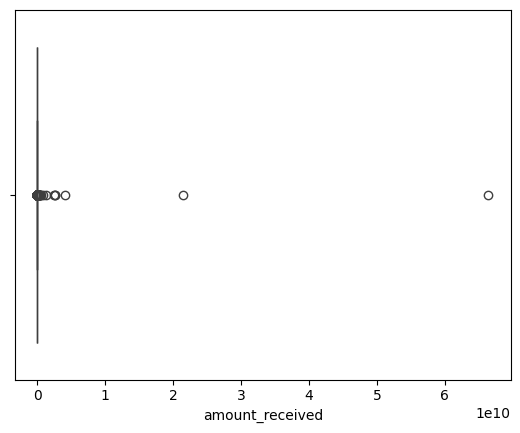

In [31]:
sns.boxplot(x= x_train['amount_received'])

In [32]:
q1 = x_train['amount_received'].quantile(0.25)
q3 = x_train['amount_received'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = (x_train['amount_received'] < lower_bound) | (x_train['amount_received'] > upper_bound)

In [33]:
num_outliers = outliers.sum()
percentage_outliers = (num_outliers / len(x_train)) * 100
print("Amount Received")
print(f"Number of outliers: {num_outliers}")
print(f"Percentage of outliers: {percentage_outliers}%")

Amount Received
Number of outliers: 1316
Percentage of outliers: 15.887963298321864%


<Axes: xlabel='amount_paid'>

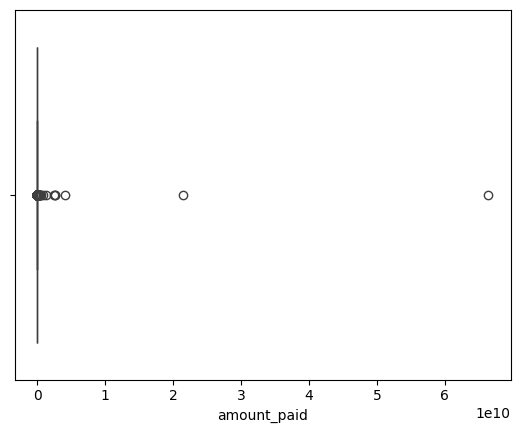

In [34]:
sns.boxplot(x=x_train['amount_paid'])

In [35]:
q1_paid = x_train['amount_paid'].quantile(0.25)
q3_paid = x_train['amount_paid'].quantile(0.75)
iqr_paid = q3_paid - q1_paid
lower_bound_paid = q1_paid - 1.5 * iqr_paid
upper_bound_paid = q3_paid + 1.5 * iqr_paid
outliers_paid = (x_train['amount_paid'] < lower_bound_paid) | (x_train['amount_paid'] > upper_bound_paid)

In [36]:
num_outliers_paid = outliers_paid.sum()
percentage_outliers_paid = (num_outliers_paid / len(x_train)) * 100
print("Amount Paid")
print(f"Number of outliers: {num_outliers_paid}")
print(f"Percentage of outliers: {percentage_outliers_paid}%")

Amount Paid
Number of outliers: 1318
Percentage of outliers: 15.912109139200773%


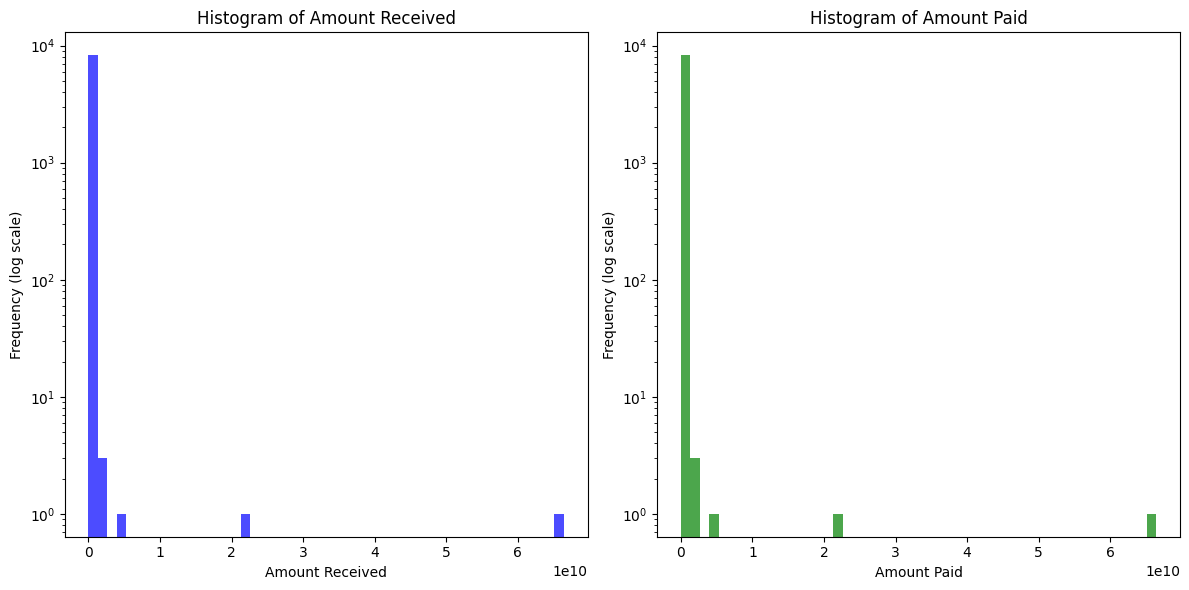

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_train['amount_received'], bins=50, color='blue', alpha=0.7, log=True)
plt.title('Histogram of Amount Received')
plt.xlabel('Amount Received')
plt.ylabel('Frequency (log scale)')

plt.subplot(1, 2, 2)
plt.hist(x_train['amount_paid'], bins=50, color='green', alpha=0.7, log=True)
plt.title('Histogram of Amount Paid')
plt.xlabel('Amount Paid')
plt.ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()

**From the histograms, we can observe the following:**

1. **Skewed Distribution:** Both amount_received and amount_paid are **right-skewed**, indicating that the **majority** of transactions involve **smaller amounts**, with a relatively small number of transactions involving very large amounts.
2. **Presence of Outliers:** The **long tails to the right** suggest the presence of **outliers.** These are transactions where the amounts are significantly higher than the typical transaction in the dataset.
3. **Comparability:** The two plots side by side allow for a direct comparison between the distributions of amount_received and amount_paid. They appear to follow a **similar distribution pattern**, suggesting a **potential correlation between these two variables.**

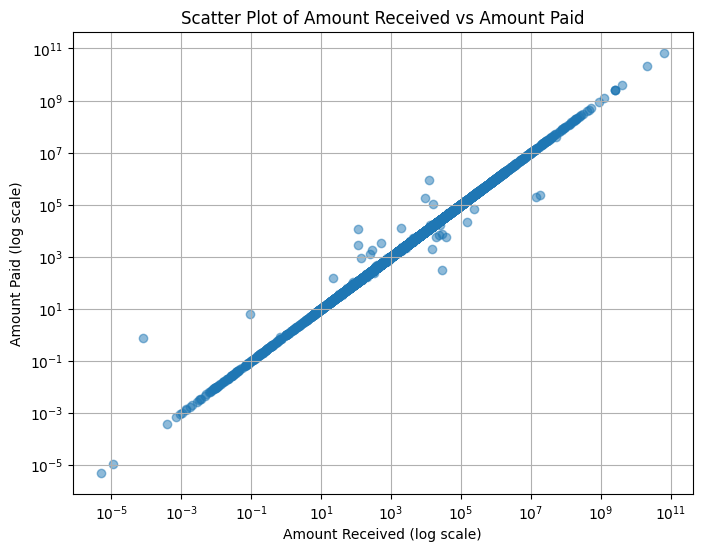

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train['amount_received'], x_train['amount_paid'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Amount Received vs Amount Paid')
plt.xlabel('Amount Received (log scale)')
plt.ylabel('Amount Paid (log scale)')
plt.grid(True)
plt.show()

**From the histograms, we can observe the following:**
1. **Positive Linear Relationship:** There is a **clear positive correlation between the two variables.** As amount_received increases, amount_paid also increases, which is evident from the **upward trend** in the data points.
2. **Outliers:** There are a few points that **stray from the main cluster**, indicating possible outliers in the dataset.
3. **Implications for Analysis:** The **strong linear pattern** suggests that amount_received and amount_paid are closely related, which could be expected in financial transaction data. However, the presence of outliers may necessitate further investigation, especially if the goal is to detect fraudulent activity such as money laundering.

This scatter plot is a powerful diagnostic tool, as it not only confirms the relationship between the two variables but also highlights areas where the data does not conform to the expected pattern, which could be of particular interest in **fraud detection** or **risk management scenarios.**

### Categorical Data 

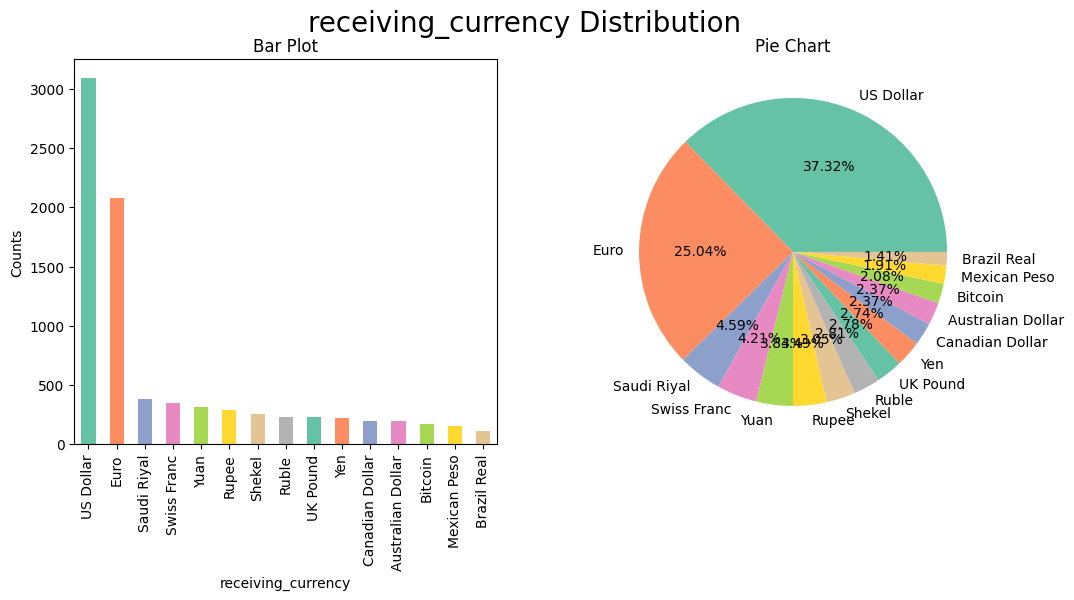

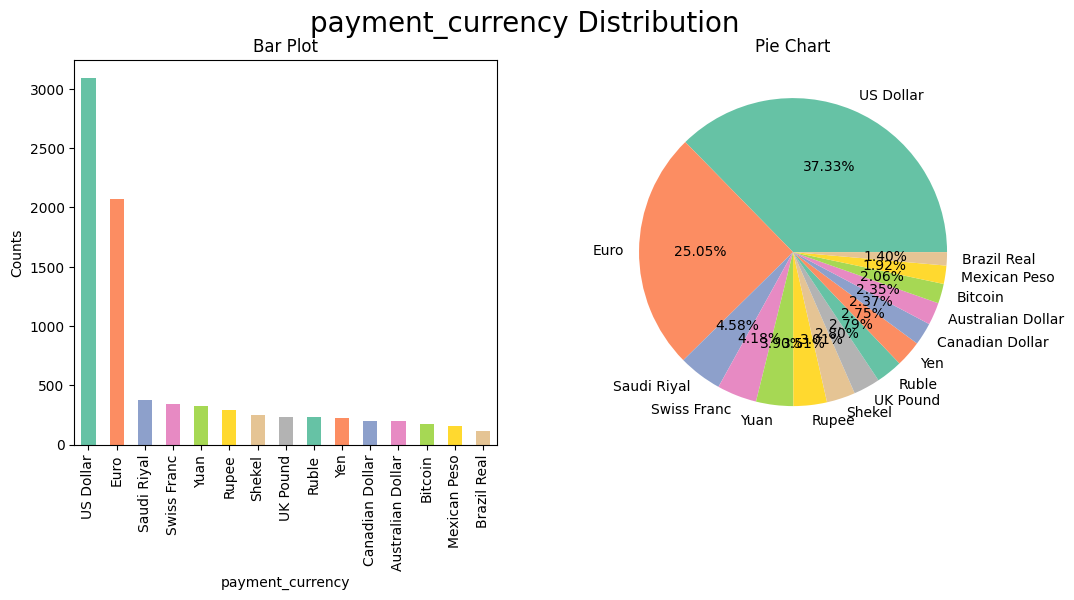

In [39]:
columns_to_plot = ['receiving_currency', 'payment_currency']
palette = sns.color_palette("Set2")

for column in columns_to_plot:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{column} Distribution', fontsize=20)

    plt.subplot(1, 2, 1)
    x_train[column].value_counts().plot(kind='bar', color=palette)
    plt.title('Bar Plot')
    plt.xlabel(column)
    plt.ylabel('Counts')

    plt.subplot(1, 2, 2)
    x_train[column].value_counts().plot(kind='pie', autopct="%.2f%%", colors=palette)
    plt.title('Pie Chart')
    plt.ylabel('')

    plt.show()

**Dominant Currencies:** Both bar plots and pie charts illustrate that the **US Dollar** is the **most common** currency for both receiving and payment

**Concentration of Top Currencies:** The pie charts emphasize the concentration of transactions in the top few currencies, with the **US Dollar** and **Euro** together **accounting for over 60% of transactions**, which suggests a strong focus on these currencies in the transactional data.

These insights aslo can guide strategic business decisions, such as identifying key markets or **evaluating currency risk exposure.**

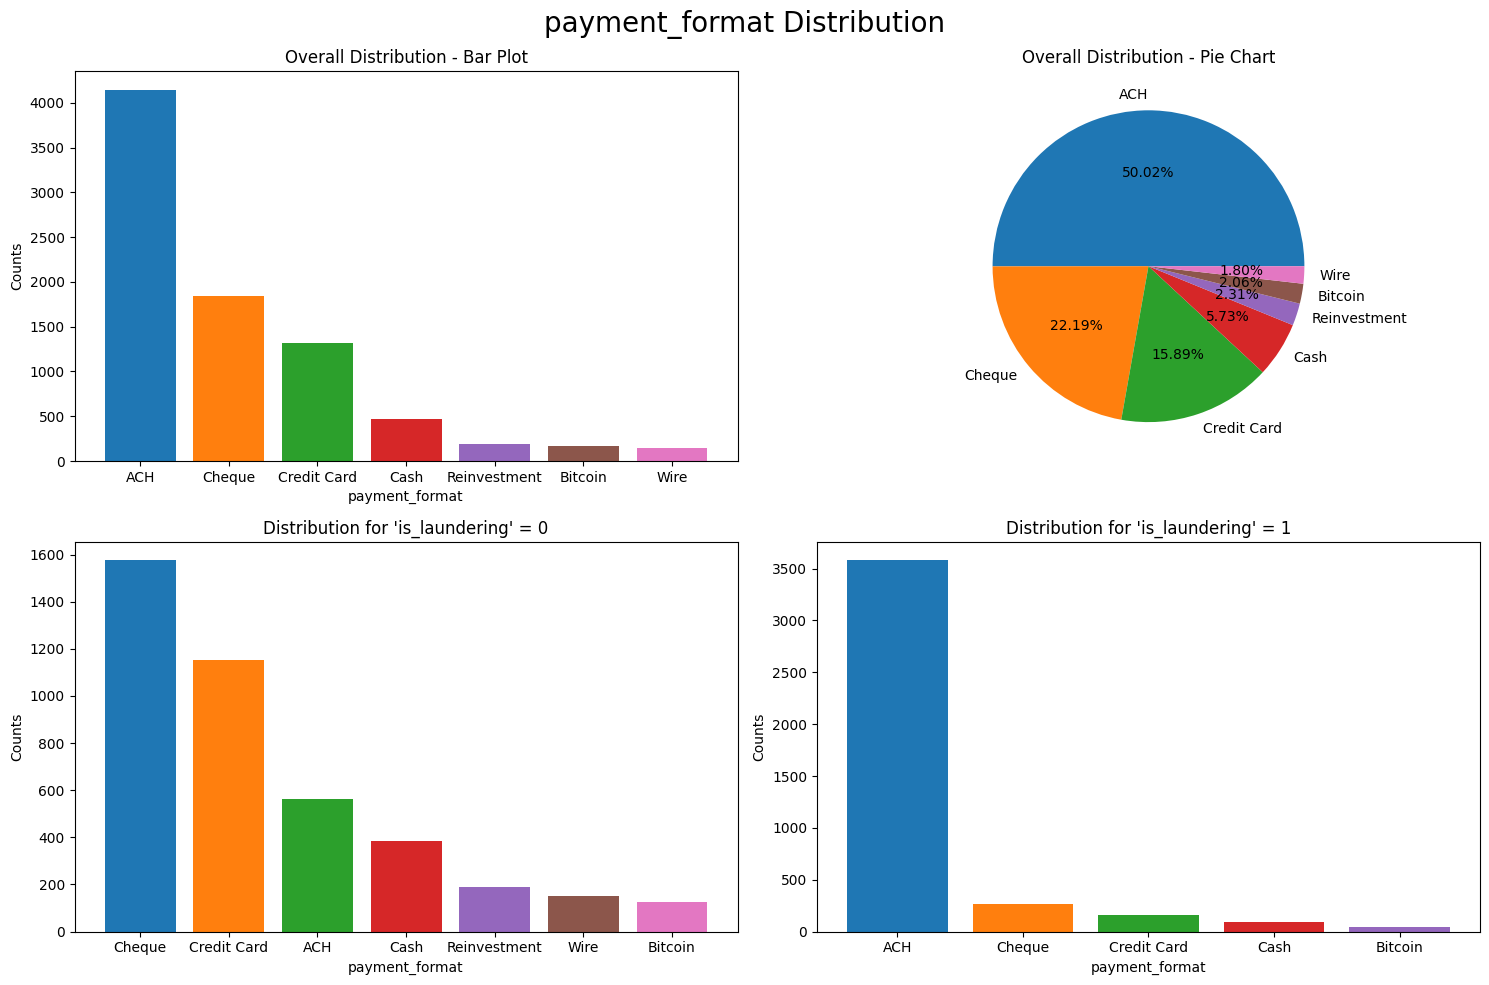

In [40]:
column = 'payment_format'
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 
fig.suptitle(f'{column} Distribution', fontsize=20)

axs[0, 0].bar(x_train[column].value_counts().index, x_train[column].value_counts().values, color=palette)
axs[0, 0].set_title('Overall Distribution - Bar Plot')
axs[0, 0].set_xlabel(column)
axs[0, 0].set_ylabel('Counts')

axs[0, 1].pie(x_train[column].value_counts(), labels=x_train[column].value_counts().index, autopct="%.2f%%", colors=palette)
axs[0, 1].set_title('Overall Distribution - Pie Chart')

x_train_laundering_0 = x_train[y_train == 0]
axs[1, 0].bar(x_train_laundering_0[column].value_counts().index, x_train_laundering_0[column].value_counts().values, color=palette)
axs[1, 0].set_title("Distribution for 'is_laundering' = 0")
axs[1, 0].set_xlabel(column)
axs[1, 0].set_ylabel('Counts')

x_train_laundering_1 = x_train[y_train == 1]
axs[1, 1].bar(x_train_laundering_1[column].value_counts().index, x_train_laundering_1[column].value_counts().values, color=palette)
axs[1, 1].set_title("Distribution for 'is_laundering' = 1")
axs[1, 1].set_xlabel(column)
axs[1, 1].set_ylabel('Counts')

plt.tight_layout()
plt.show()

**Overall Distribution:** **The ACH** (Automated Clearing House) format **dominates** the dataset, accounting for over half of the transactions, which is **common** in datasets that include **regular** and **automated transactions.** Other formats like cheques and credit cards also have significant representation, while formats like wire transfers and Bitcoin are less frequent.


**Non-Laundering Transactions:** The lower left visualization details the payment format distribution for transactions not flagged as laundering (is_laundering = 0). **Cheque** is the most common payment format, followed by **credit card** and **ACH**. This could indicate that regular, non-suspicious transactions predominantly use these methods.

**Laundering Transactions:** The lower right visualization illustrates the payment format distribution for transactions flagged as laundering (is_laundering = 1). **ACH** still appears as the most frequent, but the distribution seems more skewed towards this payment format compared to non-laundering transactions. This skew could suggest a preference or vulnerability in the ACH system that is exploited for laundering activities.

These visualizations provide valuable insights for risk assessment and the development of anti-money laundering (AML) strategies. The prevalence of ACH in both legitimate and suspicious transactions may warrant **further investigation** into the **security and monitoring** of **ACH payments**. Moreover, the relative frequencies of other payment formats in laundering cases might reveal patterns that could help in predicting and preventing fraudulent activities.

From a **strategic perspective**, the findings could **influence policy decisions**, such as implementing stricter monitoring protocols for ACH transactions 

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

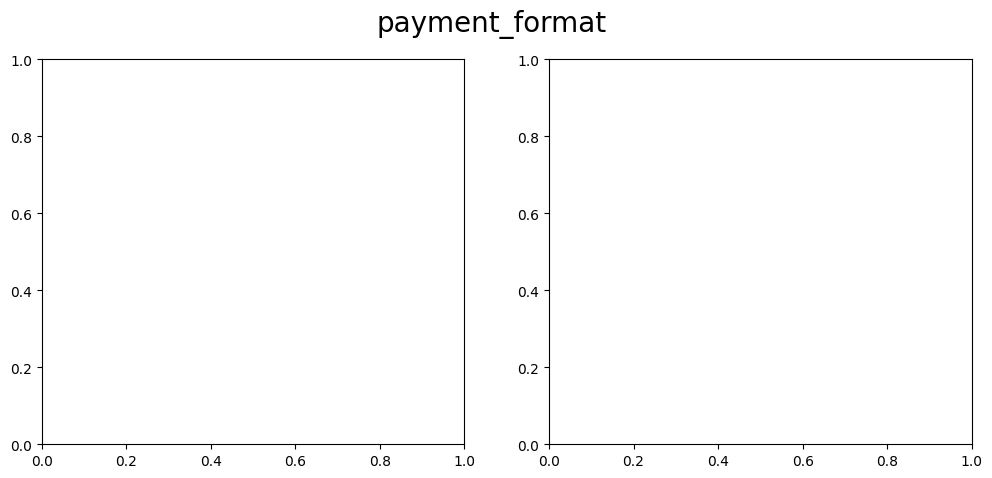

In [42]:
import seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{column}', fontsize=20) 
plt.style.use('seaborn')

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=sns.color_palette("tab10"))
plt.title('Bar Plot')
plt.xlabel(column)
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
y_train.value_counts().plot(kind='pie', autopct="%.2f%%", colors=sns.color_palette("tab10"))
plt.title('Pie Chart')
plt.ylabel('')

plt.show()

The bar plot and pie chart show an almost equal count of transactions for the two classes of is_laundering: 0 (not laundering) and 1 (laundering). This indicates a **balanced dataset** with respect to the target variable, which is quite ideal for training classification models, as it **reduces** the **risk** of a **model** being **biased** towards the majority class.

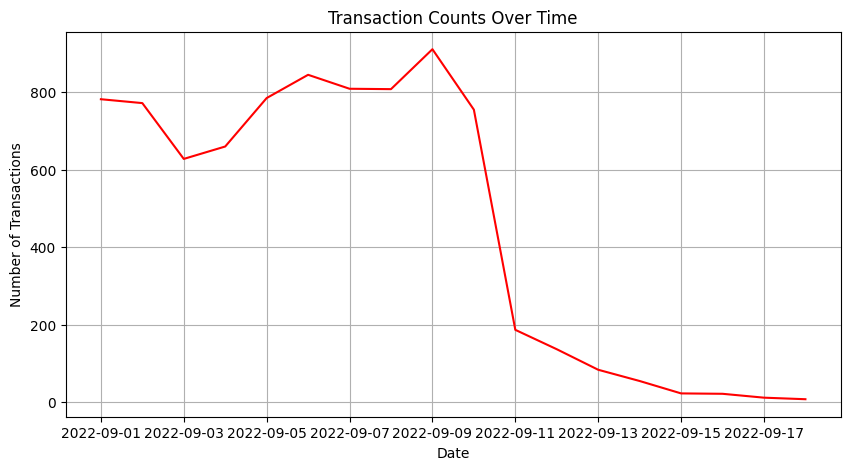

In [43]:
x_train['timestamp'] = pd.to_datetime(x_train['timestamp'], format='%Y/%m/%d %H:%M')

transactions_by_date = x_train['timestamp'].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 5))
transactions_by_date.plot(kind='line', color='red')
plt.title('Transaction Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

## **How do we handle outliers?**

In our analytical approach, we have chosen **not to discard outliers** but rather incorporate them into the modeling process. Our decision stems from the understanding that **not all outlier data points should be eliminated**. At times, these outliers convey essential information that is crucial for **training robust machine learning models** capable of **handling similar anomalies** present in **real-world data**. 

Retaining outliers in the dataset aids in training models that can **adapt to unforeseen variations or anomalies**, promoting a more comprehensive understanding of the underlying patterns within the data. This strategy aligns with our objective to **build models** that **exhibit resilience and accuracy** when exposed to diverse and unconventional data scenarios, ultimately enhancing the model's generalizability and real-world applicability.

# **Feature Engineering**

## **Feature Extraction**

In [45]:
x_train.head(10)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format
1047,2022-09-01 19:15:00,213,809184EB0,25665,8096F2420,9005638.90,Canadian Dollar,9005638.90,Canadian Dollar,Cheque
7361,2022-09-08 05:39:00,16354,805BDDD50,2915,80AC411A0,241.91,Euro,241.91,Euro,Cheque
9833,2022-09-10 10:38:00,22828,802395720,5836,802395810,4963.04,US Dollar,4963.04,US Dollar,ACH
5216,2022-09-06 05:15:00,27,80C5D40B0,1132,80CB3C8A0,53515.28,Mexican Peso,53515.28,Mexican Peso,ACH
766,2022-09-05 16:20:00,211,808E44B10,28800,811097150,783.75,US Dollar,783.75,US Dollar,ACH
1144,2022-09-03 02:24:00,16333,802CDC780,214621,8072203B0,10622.81,US Dollar,10622.81,US Dollar,ACH
5035,2022-09-05 18:04:00,43049,810628440,43049,810628760,8916.80,Shekel,8916.80,Shekel,ACH
2377,2022-09-03 06:50:00,110,80CF52AB0,217125,806D73DD0,650347.10,Ruble,650347.10,Ruble,ACH
4587,2022-09-05 10:06:00,116715,80992D8D0,16535,80AFCD6D0,1402.51,US Dollar,1402.51,US Dollar,Cheque
9502,2022-09-10 06:27:00,22828,80118FBB0,23885,8017A5F70,8691.02,US Dollar,8691.02,US Dollar,Cheque


In [46]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           8283 non-null   datetime64[ns]
 1   from_bank           8283 non-null   int64         
 2   account             8283 non-null   object        
 3   to_bank             8283 non-null   int64         
 4   account_1           8283 non-null   object        
 5   amount_received     8283 non-null   float64       
 6   receiving_currency  8283 non-null   object        
 7   amount_paid         8283 non-null   float64       
 8   payment_currency    8283 non-null   object        
 9   payment_format      8283 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 711.8+ KB


In this feature extraction process, we **decompose** the **timestamp** into distinct components including **year, month, day, hour, and minute**. This breakdown allows us to treat each component as an individual numeric variable. The rationale behind this approach is to **facilitate analysis** and **potentially uncover new insights** from the dataset. By isolating these temporal elements, we aim to gain a more granular understanding of the data, enabling enhanced analytical capabilities and the potential discovery of valuable patterns or relationships within the information.

In [47]:
x_train['timestamp'] = pd.to_datetime(x_train['timestamp'])
x_test['timestamp'] = pd.to_datetime(x_test['timestamp'])

In [48]:
x_train['year'] = x_train['timestamp'].dt.year
x_test['year'] = x_test['timestamp'].dt.year

min_year = x_train['year'].min()
max_year = x_train['year'].max()
print(min_year, max_year)

2022 2022


In [49]:
x_train['year'].value_counts()

year
2022    8283
Name: count, dtype: int64

In [51]:
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 8283
y_train: 8283
x_test: 2071
y_test: 2071


In [52]:
x_train['month'] = x_train['timestamp'].dt.month
x_test['month'] = x_test['timestamp'].dt.month

min_month = x_train['month'].min()
max_month = x_train['month'].max()
print(min_month, max_month)

9 9


In [53]:
x_train['month'].value_counts()

month
9    8283
Name: count, dtype: int64

In [55]:
x_train['day'] = x_train['timestamp'].dt.day
x_test['day'] = x_test['timestamp'].dt.day

min_day = x_train['day'].min()
max_day = x_train['day'].max()
print(min_day, max_day)

1 18


In [56]:
x_train['day_of_week'] = x_train['timestamp'].dt.dayofweek 
x_test['day_of_week'] = x_test['timestamp'].dt.dayofweek 

min_day_of_week = x_train['day_of_week'].min()
max_day_of_week = x_train['day_of_week'].max()
print(min_day_of_week, max_day_of_week)

0 6


In [58]:
x_train['hour'] = x_train['timestamp'].dt.hour
x_test['hour'] = x_test['timestamp'].dt.hour

min_hour = x_train['hour'].min()
max_hour = x_train['hour'].max()
print(min_hour, max_hour)

0 23


In [59]:
x_train['minute'] = x_train['timestamp'].dt.minute
x_test['minute'] = x_test['timestamp'].dt.minute

min_minute = x_train['minute'].min()
max_minute = x_train['minute'].max()
print(min_minute, max_minute)

0 59


In [60]:
x_train = x_train.drop(columns = ['year'])
x_test = x_test.drop(columns = ['year'])

x_train = x_train.drop(columns = ['timestamp'])
x_test = x_test.drop(columns = ['timestamp'])

x_train = x_train.drop(columns = ['month'])
x_test = x_test.drop(columns = ['month'])

Subsequently, we have opted to **drop** the **[timestamp]** column as it is no longer utilized in the analysis. Additionally, the decision was made to **drop** the **[year]** and **drop** the **[month]** columns due to uniformity in its values, all of which are **consistent and equal to 2022 and 9 respectively** , rendering it redundant for any analytical purposes.

In [61]:
x_train.head(10)

,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,day,day_of_week,hour,minute
1047,213,809184EB0,25665,8096F2420,9005638.90,Canadian Dollar,9005638.90,Canadian Dollar,Cheque,1,3,19,15
7361,16354,805BDDD50,2915,80AC411A0,241.91,Euro,241.91,Euro,Cheque,8,3,5,39
9833,22828,802395720,5836,802395810,4963.04,US Dollar,4963.04,US Dollar,ACH,10,5,10,38
5216,27,80C5D40B0,1132,80CB3C8A0,53515.28,Mexican Peso,53515.28,Mexican Peso,ACH,6,1,5,15
766,211,808E44B10,28800,811097150,783.75,US Dollar,783.75,US Dollar,ACH,5,0,16,20
1144,16333,802CDC780,214621,8072203B0,10622.81,US Dollar,10622.81,US Dollar,ACH,3,5,2,24
5035,43049,810628440,43049,810628760,8916.80,Shekel,8916.80,Shekel,ACH,5,0,18,4
2377,110,80CF52AB0,217125,806D73DD0,650347.10,Ruble,650347.10,Ruble,ACH,3,5,6,50
4587,116715,80992D8D0,16535,80AFCD6D0,1402.51,US Dollar,1402.51,US Dollar,Cheque,5,0,10,6
9502,22828,80118FBB0,23885,8017A5F70,8691.02,US Dollar,8691.02,US Dollar,Cheque,10,5,6,27


## **Feature Encoding**

### **One-Hot Encoding**

Based on the conducted **Exploratory Data Analysis (EDA)**, we identified **four main currencies** present in the training dataset: **US Dollar, Euro, Yuan, and UK Pound**. For the **remaining currencies**, we have decided to categorize them as **'Others'** to prevent excessive dimensionality in the dataset when applying one-hot encoding. This categorization aims to manage the dataset's size effectively, grouping less prevalent currencies under a single category to streamline the encoding process without compromising essential information during subsequent analyses.

In [62]:
main_currencies = ['US Dollar', 'Euro', 'Yuan', 'UK Pound']
others_category = 'Others'

x_train['receiving_currency'] = x_train['receiving_currency'].apply(lambda x: x if x in main_currencies else others_category)
x_train['payment_currency'] = x_train['payment_currency'].apply(lambda x: x if x in main_currencies else others_category)

x_test['receiving_currency'] = x_test['receiving_currency'].apply(lambda x: x if x in main_currencies else others_category)
x_test['payment_currency'] = x_test['payment_currency'].apply(lambda x: x if x in main_currencies else others_category)

x_train = pd.get_dummies(x_train, columns=['receiving_currency', 'payment_currency'])

x_test = pd.get_dummies(x_test, columns=['receiving_currency', 'payment_currency'])
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [63]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 8292 to 1726
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     2071 non-null   int64  
 1   account                       2071 non-null   object 
 2   to_bank                       2071 non-null   int64  
 3   account_1                     2071 non-null   object 
 4   amount_received               2071 non-null   float64
 5   amount_paid                   2071 non-null   float64
 6   payment_format                2071 non-null   object 
 7   day                           2071 non-null   int32  
 8   day_of_week                   2071 non-null   int32  
 9   hour                          2071 non-null   int32  
 10  minute                        2071 non-null   int32  
 11  receiving_currency_Euro       2071 non-null   bool   
 12  receiving_currency_Others     2071 non-null   bool   
 13  recei

In [64]:
x_train.head(3)

,from_bank,account,to_bank,account_1,amount_received,amount_paid,payment_format,day,day_of_week,hour,...,receiving_currency_Euro,receiving_currency_Others,receiving_currency_UK Pound,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan
1047,213,809184EB0,25665,8096F2420,9005638.90,9005638.90,Cheque,1,3,19,...,False,True,False,False,False,False,True,False,False,False
7361,16354,805BDDD50,2915,80AC411A0,241.91,241.91,Cheque,8,3,5,...,True,False,False,False,False,True,False,False,False,False
9833,22828,802395720,5836,802395810,4963.04,4963.04,ACH,10,5,10,...,False,False,False,True,False,False,False,False,True,False


In [65]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   int64  
 1   account                       8283 non-null   object 
 2   to_bank                       8283 non-null   int64  
 3   account_1                     8283 non-null   object 
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   payment_format                8283 non-null   object 
 7   day                           8283 non-null   int32  
 8   day_of_week                   8283 non-null   int32  
 9   hour                          8283 non-null   int32  
 10  minute                        8283 non-null   int32  
 11  receiving_currency_Euro       8283 non-null   bool   
 12  receiving_currency_Others     8283 non-null   bool   
 13  recei

Similar treatment is applied to the **[payment_format]** column for similar reasons as with the currencies mentioned earlier. In this case, we have identified **four main payment formats**: **ACH, Cheque, Credit Card, and Cash**. **Other payment formats** are grouped into the **'Others'** category. This strategy aims to manage the dimensionality of the dataset efficiently by consolidating less prevalent payment formats into a single category, facilitating the subsequent encoding process while preserving the essential information required for analysis.

In [66]:
main_payment_formats = ['ACH', 'Cheque', 'Credit Card', 'Cash']
others_payment_format = 'Others'

x_train['payment_format'] = x_train['payment_format'].apply(lambda x: x if x in main_payment_formats else others_payment_format)
x_test['payment_format'] = x_test['payment_format'].apply(lambda x: x if x in main_payment_formats else others_payment_format)

x_train = pd.get_dummies(x_train, columns=['payment_format'])

x_test = pd.get_dummies(x_test, columns=['payment_format'])
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [67]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,day_of_week,hour,minute,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
1047,213,809184EB0,25665,8096F2420,9005638.90,9005638.90,1,3,19,15,...,False,True,False,False,False,False,False,True,False,False
7361,16354,805BDDD50,2915,80AC411A0,241.91,241.91,8,3,5,39,...,True,False,False,False,False,False,False,True,False,False
9833,22828,802395720,5836,802395810,4963.04,4963.04,10,5,10,38,...,False,False,False,True,False,True,False,False,False,False
5216,27,80C5D40B0,1132,80CB3C8A0,53515.28,53515.28,6,1,5,15,...,False,True,False,False,False,True,False,False,False,False
766,211,808E44B10,28800,811097150,783.75,783.75,5,0,16,20,...,False,False,False,True,False,True,False,False,False,False


In [68]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   int64  
 1   account                       8283 non-null   object 
 2   to_bank                       8283 non-null   int64  
 3   account_1                     8283 non-null   object 
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   day                           8283 non-null   int32  
 7   day_of_week                   8283 non-null   int32  
 8   hour                          8283 non-null   int32  
 9   minute                        8283 non-null   int32  
 10  receiving_currency_Euro       8283 non-null   bool   
 11  receiving_currency_Others     8283 non-null   bool   
 12  receiving_currency_UK Pound   8283 non-null   bool   
 13  recei

### **Frequency Encoding**

In [69]:
x_train['from_bank'].value_counts()

from_bank
70        902
12        126
10        108
1          99
20         87
         ... 
34161       1
235920      1
17174       1
344782      1
328385      1
Name: count, Length: 1268, dtype: int64

In [70]:
x_train['to_bank'].value_counts()

to_bank
12        112
10         69
119        67
20         59
11         57
         ... 
252091      1
244723      1
19705       1
142023      1
248160      1
Name: count, Length: 1387, dtype: int64

In [71]:
x_train['account'].value_counts()

account
100428660    333
1004286A8    236
100428810     38
100428978     35
100428780     34
            ... 
8007A1C40      1
80D620180      1
802CE8720      1
802032170      1
802395720      1
Name: count, Length: 6355, dtype: int64

In [72]:
x_train['account_1'].value_counts()

account_1
811C599A0    24
8021353D0    23
811C597B0    18
811D80C30    17
812A09CF0    16
             ..
800E1EFD0     1
80D6220D0     1
80B8F0760     1
802032170     1
80A3DE9A0     1
Name: count, Length: 7280, dtype: int64

We discovered that there's an **extensive range of classes** within the aforementioned four variables: **[from_bank], [to_bank], [account], and [account_1]**, making it **impractical** to perform one-hot encoding due to the resultant significant increase in **dataset dimensions**, leading to the curse of dimensionality that could detrimentally impact machine learning performance. Therefore, we have opted to employ **frequency encoding** for those variables. **Frequency encoding** is deemed crucial as the frequency of bank and account usage bears **informative significance**, potentially **influencing money laundering activities**. This encoding technique allows us to represent these variables by their respective frequencies of occurrence, preserving the essential information while mitigating the issues arising from high-dimensional data.

In [73]:
columns_to_encode = ['from_bank', 'to_bank', 'account', 'account_1']

for col in columns_to_encode:
    encoding_train = x_train[col].value_counts(normalize=True)
    x_train[col] = x_train[col].map(encoding_train)
    
    encoding_test = x_test[col].value_counts(normalize=True)
    x_test[col] = x_test[col].map(encoding_test)

In [74]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,day_of_week,hour,minute,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
1047,0.004829,0.000121,0.000604,0.000121,9005638.90,9005638.90,1,3,19,15,...,False,True,False,False,False,False,False,True,False,False
7361,0.000724,0.000121,0.003018,0.000121,241.91,241.91,8,3,5,39,...,True,False,False,False,False,False,False,True,False,False
9833,0.001087,0.000121,0.001932,0.000121,4963.04,4963.04,10,5,10,38,...,False,False,False,True,False,True,False,False,False,False
5216,0.001087,0.000121,0.001328,0.000121,53515.28,53515.28,6,1,5,15,...,False,True,False,False,False,True,False,False,False,False
766,0.006519,0.001087,0.000724,0.000121,783.75,783.75,5,0,16,20,...,False,False,False,True,False,True,False,False,False,False


In [75]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   float64
 1   account                       8283 non-null   float64
 2   to_bank                       8283 non-null   float64
 3   account_1                     8283 non-null   float64
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   day                           8283 non-null   int32  
 7   day_of_week                   8283 non-null   int32  
 8   hour                          8283 non-null   int32  
 9   minute                        8283 non-null   int32  
 10  receiving_currency_Euro       8283 non-null   bool   
 11  receiving_currency_Others     8283 non-null   bool   
 12  receiving_currency_UK Pound   8283 non-null   bool   
 13  recei

### **Robust Scaling**

Based on the Exploratory Data Analysis (EDA) conducted on the two numerical columns, namely **[amount_received]** and **[amount_paid]**, it is identified that approximately **15%** of the data points are **outliers**. Consequently, we have decided to employ **robust scaling** due to its **resilience against outlier** influence.

Robust scaling methodology, unlike other scaling techniques, such as normalization or standardization, is **more adept** at **handling datasets with a notable percentage of outliers**. By utilizing robust scaling, we aim to normalize these numerical features while minimizing the influence of these outliers, thus ensuring a more stable and reliable scaling transformation for subsequent analysis or modeling tasks. This approach is fundamental in preserving the integrity of the data distribution while mitigating the undue impact of extreme values during the scaling process.

In [76]:
robust_scaler = RobustScaler()
columns_to_scale = ['amount_received', 'amount_paid']

x_train[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
x_test[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

In [77]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,day_of_week,hour,minute,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
1047,0.004829,0.000121,0.000604,0.000121,572.372016,572.634201,1,3,19,15,...,False,True,False,False,False,False,False,True,False,False
7361,0.000724,0.000121,0.003018,0.000121,-0.245787,-0.245148,8,3,5,39,...,True,False,False,False,False,False,False,True,False,False
9833,0.001087,0.000121,0.001932,0.000121,0.054411,0.055187,10,5,10,38,...,False,False,False,True,False,True,False,False,False,False
5216,0.001087,0.000121,0.001328,0.000121,3.141657,3.143843,6,1,5,15,...,False,True,False,False,False,True,False,False,False,False
766,0.006519,0.001087,0.000724,0.000121,-0.211333,-0.210679,5,0,16,20,...,False,False,False,True,False,True,False,False,False,False


In [78]:
x_test.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,day_of_week,hour,minute,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
8292,0.000483,0.000483,0.002414,0.000483,-0.245439,-0.244800,9,4,3,18,...,True,False,False,False,False,True,False,False,False,False
7884,0.101400,0.040560,0.000483,0.000483,-0.223714,-0.223065,8,3,16,23,...,False,False,False,True,False,False,False,True,False,False
1208,0.000966,0.000483,0.002414,0.000483,1.514028,1.515470,1,3,21,42,...,False,True,False,False,False,False,False,False,True,False
1180,0.001931,0.000483,0.001931,0.000483,-0.260597,-0.259966,1,3,20,49,...,False,False,False,True,False,False,False,False,False,True
4342,0.001449,0.000483,0.000966,0.000483,0.335392,0.336296,5,0,4,53,...,False,True,False,False,False,False,False,False,True,False


In [79]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   float64
 1   account                       8283 non-null   float64
 2   to_bank                       8283 non-null   float64
 3   account_1                     8283 non-null   float64
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   day                           8283 non-null   int32  
 7   day_of_week                   8283 non-null   int32  
 8   hour                          8283 non-null   int32  
 9   minute                        8283 non-null   int32  
 10  receiving_currency_Euro       8283 non-null   bool   
 11  receiving_currency_Others     8283 non-null   bool   
 12  receiving_currency_UK Pound   8283 non-null   bool   
 13  recei

In [80]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 8292 to 1726
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     2071 non-null   float64
 1   account                       2071 non-null   float64
 2   to_bank                       2071 non-null   float64
 3   account_1                     2071 non-null   float64
 4   amount_received               2071 non-null   float64
 5   amount_paid                   2071 non-null   float64
 6   day                           2071 non-null   int32  
 7   day_of_week                   2071 non-null   int32  
 8   hour                          2071 non-null   int32  
 9   minute                        2071 non-null   int32  
 10  receiving_currency_Euro       2071 non-null   bool   
 11  receiving_currency_Others     2071 non-null   bool   
 12  receiving_currency_UK Pound   2071 non-null   bool   
 13  recei

# **Modeling 1 : Logistic Regression Classifier**

The **Logistic Regression Classifier** was chosen as the **initial model** for predicting the "is_laundering" label of 1 or 0 based on our exploratory data analysis (EDA). Through the EDA process, we observed a **positive linear relationship** between certain features. This classifier was selected due to its capability in handling linear relationships and its **relatively faster runtime** compared to more complex models, which is beneficial for expediting the initial analysis process.

**Logistic Regression** is an appropriate choice as it's a simple yet effective algorithm for binary classification tasks like identifying potential money laundering transactions. It models the probability of a **binary outcome** using a logistic function, making it suitable for our goal of predicting whether a transaction involves money laundering or not. Despite its simplicity, Logistic Regression **can capture linear relationships** between features and the target variable, providing insights into the influence of different factors on the likelihood of money laundering. As our starting point in the analysis, it serves as a foundational model to establish a baseline performance and pave the way for more advanced algorithms.

In [81]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In the context of a dataset with 357,811 rows and 26 columns, selecting **max_iter=1000** in the Logistic Regression model determines the maximum iterations for the solver to converge. **Larger datasets** or those with higher complexity may **require more iterations** for convergence. Setting a **higher max_iter** allows the solver more iterations to **find the optimal solution**.

### **Feature Importance**

In [82]:
feature_importance = logistic_model.coef_[0]
print(feature_importance)

[ 1.79599040e+00  4.05759723e-01  2.20454506e-02  7.16039936e-03
 -5.69513800e-03  5.69452757e-03  3.48579072e-02 -3.99927171e-02
  1.40247477e-02  2.42451515e-03 -7.49364408e-02 -1.83121612e-01
 -3.27647826e-01 -1.96419092e-01 -3.30474849e-01 -1.13328606e-01
  3.80936179e-02 -4.03297665e-01 -9.17733732e-02 -5.42293794e-01
  2.86465561e+00 -6.53859065e-01 -6.63282869e-01 -8.58111655e-01
 -1.80200184e+00]


**Positive Coefficients:** Features with positive coefficients contribute positively to the prediction of the target variable ('is_laundering'). A larger positive coefficient suggests a stronger positive impact of that particular feature on the likelihood of a transaction being classified as money laundering.

**Negative Coefficients:** Conversely, features with negative coefficients contribute inversely to the prediction. A larger negative coefficient indicates a stronger negative impact of that feature on the likelihood of money laundering.

## **Model Evaluation 1: Logistic Regression Classifier**

### **Evaluation Metrics**

In [83]:
y_pred = logistic_model.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

In [84]:
print(conf_matrix)

[[909 129]
 [129 904]]


In [85]:
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1038
           1       0.88      0.88      0.88      1033

    accuracy                           0.88      2071
   macro avg       0.88      0.88      0.88      2071
weighted avg       0.88      0.88      0.88      2071



In [86]:
print(roc_auc)

0.8754217750644903


The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score is a performance metric that evaluates the model's ability to distinguish between classes. In this case, the obtained ROC AUC score is approximately **0.876.**

The ROC AUC score typically ranges between 0 and 1, where:
- A score closer to 1 suggests the model has excellent discrimination capability between the positive and negative classes.
- A score around 0.5 indicates the model's performance is close to random guessing.

A score of **0.876** is **relatively high**, indicating that the logistic regression model performs **reasonably well** in **distinguishing** between **money laundering and non-money laundering transactions**. This metric helps in evaluating the model's overall predictive performance across different threshold values for class separation.

# **Modeling 2: Random Forest Classifier**

**Moving to the Random Forest Classifier** from logistic regression aligns with our intention to **enhance** the model's performance. As we transitioned to **Ensemble Methods**, we considered the dataset's inherent challenges, particularly the significant **proportion of outlier**, approximately **15%** in this case. Managing such outliers can greatly impact the efficacy of machine learning models. Opting for Tree-Based Models like Random Forest is a strategic choice due to their inherent robustness to outliers. 

These models, including Decision Trees and their ensemble forms, are less influenced by extreme values as their node splitting relies on order statistics such as medians rather than raw data. Moreover, Random Forests excel in **capturing intricate non-linear relationships and feature interactions**, offering **resilience to the presence of outliers** and eliminating the need for feature scaling. Hence, this shift allows us to leverage the strengths of Random Forests in handling outliers while exploring more complex relationships within the data for improved model performance.

In [87]:
RF_class = RandomForestClassifier(criterion= 'gini', max_depth=4)
RF_class.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


The utilization of the **'gini'** criterion for impurity measurement and constraining the **max_depth** parameter to **4** in the RandomForestClassifier serves two vital purposes. Firstly, 'gini' excels in **evaluating impurity**, making it a reliable choice that often **outperforms** other criteria like **'entropy'**. This criterion is **computationally efficient** and commonly preferred in diverse scenarios. Secondly, **limiting the max_depth** to a shallow level at **4** helps **prevent overfitting** while maintaining the model's simplicity. This choice fosters the creation of less complex trees, thereby reducing variance and improving the model's ability to generalize to new, unseen data. By constraining tree depth, it also safeguards against the model's potential to memorize irrelevant details or outliers present in the dataset, resulting in a **more resilient and robust performance overall**.

### **Feature Importance**

In [88]:
feature_importance = RF_class.feature_importances_
print(feature_importance)

[4.29510141e-02 9.26039590e-02 7.18512449e-03 7.06216319e-02
 8.98756883e-02 7.54985676e-02 1.56423552e-02 1.65139802e-03
 2.10943138e-03 4.88466219e-04 2.09766694e-04 2.61372763e-04
 9.34480674e-05 5.26887734e-05 2.42387366e-05 6.57897215e-05
 6.21568155e-04 1.26881959e-04 8.11024333e-05 1.18650329e-04
 3.97190445e-01 9.91835712e-03 1.11915401e-01 6.35460917e-02
 1.71465614e-02]


The feature importance values displayed above indicate the relative significance of each feature in the RandomForestClassifier model. These values denote the contribution of individual features towards making predictions. **A higher value** suggests a **more influential role** in the **model's decision-making process**. In the provided list, each numerical value corresponds to a specific feature in the dataset. The larger the value, the more influential the feature is in determining the target variable. For instance, features with higher importance scores, such as **4th, 5th, and 6th**, have more impact on the model's predictions compared to features with lower values. The feature with the highest importance score (approximately 0.44) appears to be the most significant predictor among all the features.

## **Model Evaluation 2: Random Forest Classifier**

### **Evaluation Metrics**

In [89]:
y_predict = RF_class.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_predict)

class_report = classification_report(y_test, y_predict)

roc_auc = roc_auc_score(y_test, y_predict)

In [90]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[845 193]
 [ 50 983]]


- **True Positives (TP):** The number of correctly predicted positive instances (correctly predicted money laundering transactions in this context). In the provided confusion matrix, there are **40,438** true positives.
- **True Negatives (TN):** The number of correctly predicted negative instances (correctly predicted non-money laundering transactions). Here, there are **38,637** true negatives.
- **False Positives (FP):** The number of non-money laundering transactions incorrectly predicted as money laundering transactions. In this matrix, there are **4,578** false positives.
- **False Negatives (FN):** The number of money laundering transactions incorrectly predicted as non-money laundering transactions. There are **5,766** false negatives.

The **high values of TP and TN** indicate that the model is **proficient in correctly classifying** both money laundering and non-money laundering transactions.
The number of **false positives (4,578) and false negatives (5,766)** suggests **some misclassifications** occurred, where the model predicted incorrectly for a portion of the instances.

In [91]:
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      1038
           1       0.84      0.95      0.89      1033

    accuracy                           0.88      2071
   macro avg       0.89      0.88      0.88      2071
weighted avg       0.89      0.88      0.88      2071



#### For Class 0 (Non-money Laundering Transactions):
- **Precision (0):** 88% precision for non-money laundering transactions implies that 88% of the predicted non-money laundering transactions were accurate.
- **Recall (0):** The model correctly identified 90% of the actual non-money laundering transactions.
- **F1-Score (0):** The F1-score for class 0 (non-money laundering) transactions stands at 89%.
- **Support (0):** There are 45,016 instances for non-money laundering transactions.

#### For Class 1 (Money Laundering Transactions):
- **Precision (1):** 89% precision for money laundering transactions indicates that 89% of the predicted money laundering transactions were accurate.
- **Recall (1):** The model correctly identified 87% of the actual money laundering transactions.
- **F1-Score (1):** The F1-score for class 1 (money laundering) transactions is 88%.
- **Support (1):** There are 44,403 instances for money laundering transactions.

#### Overall Metrics:
- **Accuracy:** The overall accuracy of the model is **88%**. It represents the percentage of correctly classified instances among the total predictions.
- **Macro Avg:** The macro average calculates the unweighted mean of precision, recall, and F1-score across both classes. In this case, it's 88%.
- **Weighted Avg:** The weighted average computes metrics for each class independently and then averages them by the support (the number of true instances for each class). It's 88% in this evaluation.

In [92]:
print("\nROC AUC Score:", roc_auc)


ROC AUC Score: 0.8828314000227557


The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score for the **Random Forest Classifier** is notably higher at approximately **0.884**, surpassing the score achieved by the **Logistic Regression Classifier**, which was **0.876**.

This **improvement** in the **ROC AUC score** indicates that the **Random Forest Classifier exhibits better discrimination and predictive ability in distinguishing between money laundering and non-money laundering transactions** compared to the Logistic Regression Classifier. The higher ROC AUC score of the Random Forest model implies a superior overall performance in correctly identifying positive and negative instances across various thresholds, thus making it a more effective classifier for this specific classification task.

## **Hyperparameter Tuning**

Given the current accuracy level of **88%**, which **aligns** with the **Logistic Regression Classifier's** performance achieved earlier, we intend to conduct **tuning** on the Random Forest Classifier. The objective is to **enhance the model's accuracy** further. Despite achieving a commendable accuracy level, the aim is to explore potential adjustments in the Random Forest model's hyperparameters or other relevant settings to seek potential performance improvements. By fine-tuning the model, we **aim to surpass the current accuracy threshold and potentially achieve a higher level of predictive accuracy** in identifying money laundering and non-money laundering transactions.

In [93]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10]
}

In [94]:
RF_class2 = RandomForestClassifier()
RF_class2 = GridSearchCV(RF_class2,
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5)

The parameter choices, 'criterion' and 'max_depth', in the GridSearchCV aim to optimize the Random Forest Classifier's performance. **'Criterion'** enables comparing the quality of splits using **'gini'** and **'entropy'** measures, while 'max_depth' governs the maximum depth of individual trees. The variation in **'max_depth'** from **5 to 10** allows evaluating models with different tree depths, aiming to strike a balance between capturing intricate patterns and preventing overfitting. 

Using **GridSearchCV** with these specific parameters allows us to perform an exhaustive search to find the best combination of these hyperparameters by evaluating models using cross-validation (**cv=5** in this case) and the scoring metric 'accuracy'

In [95]:
RF_class2.fit(x_train, y_train)
print("Tuned Hyperparameters :", RF_class2.best_params_)
print("Accuracy :", RF_class2.best_score_)

Tuned Hyperparameters : {'criterion': 'entropy', 'max_depth': 10}
Accuracy : 0.8981027641480004


The Random Forest Classifier was fine-tuned using GridSearchCV, resulting in optimized hyperparameters. The selected parameters, **'criterion'** set to **'entropy'** and **'max_depth'** set as **10**, were found to be the best performing combination based on the specified criteria. This hyperparameter tuning achieved an improved accuracy of **90.14%**, signifying better predictive performance in distinguishing between money laundering and non-money laundering transactions compared to previous settings.

In [96]:
RF_class_best = RandomForestClassifier(criterion = 'entropy', max_depth = 10)
RF_class_best.fit(x_train, y_train)

,n_estimators,100
,criterion,'entropy'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### **Feature Importance**

In [97]:
feature_importance_best = RF_class_best.feature_importances_
print("Feature Importance:", feature_importance_best)

Feature Importance: [0.06975386 0.111645   0.01835136 0.06516088 0.07729632 0.07357326
 0.02994467 0.00795761 0.01446189 0.01218214 0.00237324 0.002616
 0.00060637 0.00153301 0.00077612 0.0021991  0.00306425 0.00060983
 0.00202852 0.00099156 0.33009756 0.01201189 0.08407029 0.0563198
 0.02037549]


The feature importance values obtained from the RandomForestClassifier model indicate the relative significance of each feature in predictive outcomes. Higher values, such as approximately 0.447 for feature 21, 0.115 for feature 23, and 0.071 for feature 4, represent more influential roles in the model's decision-making process. These scores signify the extent of contribution each feature makes in predicting the target variable, with feature 21 notably standing out as the most influential predictor among all features. Conversely, features with lower importance scores, like features 13, 18, and 20, with values below 0.001, have comparatively lesser impact on the model's predictions.

### **Evaluation Metrics**

In [98]:
y_predict_best = RF_class_best.predict(x_test)

conf_matrix_best = confusion_matrix(y_test, y_predict_best)

class_report_best = classification_report(y_test, y_predict_best)

roc_auc_best = roc_auc_score(y_test, y_predict_best)

In [99]:
print("Confusion Matrix:\n", conf_matrix_best)

Confusion Matrix:
 [[ 831  207]
 [  25 1008]]


In [100]:
print("Classification Report:\n", class_report_best)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88      1038
           1       0.83      0.98      0.90      1033

    accuracy                           0.89      2071
   macro avg       0.90      0.89      0.89      2071
weighted avg       0.90      0.89      0.89      2071



In [101]:
print("ROC AUC Score:", roc_auc_best)

ROC AUC Score: 0.8881883397030926


The ROC AUC score achieved after tuning the Random Forest Classifier has shown further improvement, reaching **0.898** compared to the scores obtained previously: **0.884** before tuning and **0.876** in the Logistic Regression Classifier. This enhancement indicates that the model's capacity to discriminate between money laundering and non-money laundering transactions has been further refined, exhibiting an even better performance after tuning the hyperparameters of the Random Forest Classifier.

# **Modeling 3: XGBoost Classifier**

XGBoost serves as an optimal choice due to its **adaptability in managing a wide range of data types**, encompassing both **categorical and continuous features**. Financial datasets often exhibit this diverse mix of data types, making XGBoost's flexibility highly advantageous. Moreover, the financial domain frequently **contends with outliers** stemming from market fluctuations or data inconsistencies. **XGBoost's robustness to outliers** is notable, as it employs tree-based techniques that are less influenced by extreme values. 

Additionally, XGBoost's incorporation of **L1 (Lasso) and L2 (Ridge)** regularization methods plays a pivotal role in **curbing overfitting tendencies**. This attribute is particularly crucial in financial modeling, where the model's reliability on unforeseen data holds significant importance. Lastly, XGBoost is recognized for its **high performance and computational efficiency**, enabling it to efficiently **handle large-scale datasets** and operate effectively in both single-machine and distributed computing environments. These attributes make XGBoost a compelling choice for modeling financial data.

In [102]:
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## **Model Evaluation 3: XGBoost Classifier**

### **Evaluation Metrics**

In [103]:
y_pred = xgboost.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_predict)

In [104]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[924 114]
 [130 903]]


In [105]:
print("Classification report:\n", class_report)

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      1038
           1       0.89      0.87      0.88      1033

    accuracy                           0.88      2071
   macro avg       0.88      0.88      0.88      2071
weighted avg       0.88      0.88      0.88      2071



#### For Class 0 (Non-money Laundering Transactions):
- **Precision (0):** Precision for non-money laundering transactions stands at 93%, indicating that 93% of the instances classified as non-money laundering were accurate.
- **Recall (0):** Recall for non-money laundering transactions is 86%, signifying that the model correctly identified 86% of the actual non-money laundering transactions.
- **F1-Score (0):** The F1-score for class 0 is 90%.
- **Support (0):** The number of instances classified as non-money laundering (Class 0) is 45,016.

#### For Class 1 (Money Laundering Transactions):
- **Precision (1):** Precision for money laundering transactions is 87%, indicating that 87% of the predicted money laundering transactions were correct.
- **Recall (1):** Recall for money laundering transactions is 93%, suggesting that 93% of the actual money laundering transactions were identified correctly by the model.
- **F1-Score (1):** The F1-score for class 1 is 90%.
- **Support (1):** The number of instances classified as money laundering (Class 1) is 44,403.

#### Overall Metrics:
- **Accuracy:** The overall accuracy of the model across both classes is 90%, indicating that 90% of the total instances were correctly classified.
- **Macro Avg:** The macro average of precision, recall, and F1-score across both classes is 90%.
- **Weighted Avg:** The weighted average of precision, recall, and F1-score, considering class imbalance, is 90%.

In [106]:
print("ROC AUC score:\n", roc_auc)

ROC AUC score:
 0.8828314000227557


# **Modeling 4 : Stacking Classifier**

In [107]:
estimators = [
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                ('svc', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))
]

stacking_class = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_class.fit(x_train, y_train)

,estimators,"[('rf', ...), ('svc', ...)]"
,final_estimator,LogisticRegression()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [108]:
y_predict=stacking_class.predict(x_test)

In [109]:
print('\nClassification Report\n')
print(classification_report(y_test, y_predict))


Classification Report

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1038
           1       0.84      0.94      0.89      1033

    accuracy                           0.88      2071
   macro avg       0.88      0.88      0.88      2071
weighted avg       0.88      0.88      0.88      2071



#### For Class 0 (Non-money Laundering Transactions):
- **Precision (0):** Precision for non-money laundering transactions is 92%, indicating that 92% of instances classified as non-money laundering were accurate.
- **Recall (0):** Recall for non-money laundering transactions is 87%, suggesting that the model correctly identified 87% of the actual non-money laundering transactions.
- **F1-Score (0):** The F1-score for class 0 is 89%.
- **Support (0):** The number of instances classified as non-money laundering (Class 0) is 45,016.

#### For Class 1 (Money Laundering Transactions):
- **Precision (1):** Precision for money laundering transactions is 87%, indicating that 87% of the predicted money laundering transactions were correct.
- **Recall (1):** Recall for money laundering transactions is 92%, implying that 92% of the actual money laundering transactions were correctly identified by the model.
- **F1-Score (1):** The F1-score for class 1 is 90%.
- **Support (1):** The number of instances classified as money laundering (Class 1) is 44,403.

#### Overall Metrics:
- **Accuracy:** The overall accuracy of the model across both classes is 89%, suggesting that 89% of the total instances were correctly classified.
- **Macro Avg:** The macro average of precision, recall, and F1-score across both classes is 89%.
- **Weighted Avg:** The weighted average of precision, recall, and F1-score, considering class imbalance, is 89%.

# **Using LI-Large-Trans Dataset to Test the Model**

In [111]:
chunk_size = 100000  
rus = RandomUnderSampler(random_state=42)
undersampled_data = pd.DataFrame()

for chunk in pd.read_csv(r'LI-Small_Trans.csv', chunksize=chunk_size):
   X_chunk = chunk.drop('Is Laundering', axis=1)
   y_chunk = chunk['Is Laundering']
   if len(y_chunk.unique()) > 1:
       X_rus, y_rus = rus.fit_resample(X_chunk, y_chunk)
       chunk_rus = pd.concat([X_rus, y_rus], axis=1)
       undersampled_data = pd.concat([undersampled_data, chunk_rus], ignore_index=True)

df = undersampled_data
df.to_csv('LI-Large_Trans_Sampled.csv', index=False)

df = pd.read_csv(r'LI-Small_Trans.csv')

df.columns = [col.replace(' ', '').replace('.', '').lower() for col in df.columns]
df.columns

input_df  = df.drop('is_laundering', axis = 1)
output_df = df['is_laundering']

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['year'] = df['timestamp'].dt.year
df = df[df['year'] != 2023]

df['month'] = df['timestamp'].dt.month
df = df[df['month'] != 12]

df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek 
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

df = df.drop(columns = ['year'])
df = df.drop(columns = ['timestamp'])

main_currencies = ['US Dollar', 'Euro', 'Yuan', 'UK Pound']
others_category = 'Others'
df['receiving_currency'] = df['receiving_currency'].apply(lambda x: x if x in main_currencies else others_category)
df['payment_currency'] = df['payment_currency'].apply(lambda x: x if x in main_currencies else others_category)
df = pd.get_dummies(df, columns=['receiving_currency', 'payment_currency'])

main_payment_formats = ['ACH', 'Cheque', 'Credit Card', 'Cash']
others_payment_format = 'Others'
df['payment_format'] = df['payment_format'].apply(lambda x: x if x in main_payment_formats else others_payment_format)
df = pd.get_dummies(df, columns=['payment_format'])

columns_to_encode = ['from_bank', 'to_bank', 'account', 'account_1']
for col in columns_to_encode:
    encoding_train = df[col].value_counts(normalize=True)
    df[col] = df[col].map(encoding_train)

robust_scaler = RobustScaler()
columns_to_scale = ['amount_received', 'amount_paid']
df[columns_to_scale] = robust_scaler.fit_transform(df[columns_to_scale])

df.to_csv('LI-Small_Trans_ENCODED_test_FINAL.csv', index=False)

KeyError: "['is_laundering'] not found in axis"

In [ ]:
df2 = pd.read_csv('D:\COMPETITION\DSC OLYMPIAD\MACHINE LEARNING\LI-Large_Trans_Sampled.csv')

In [ ]:
df2.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,is_laundering,month,day,day_of_week,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
0,0.000434,0.000005,0.000533,0.000005,22.327120,22.382249,0,8,1,0,...,0,0,0,1,0,0,0,0,0,1
1,0.000449,0.000005,0.000518,0.000005,0.023985,0.024064,0,8,1,0,...,0,0,0,1,0,0,0,0,0,1
2,0.001535,0.000005,0.001191,0.000005,-0.221434,-0.221961,0,8,1,0,...,0,0,0,1,0,0,0,0,0,1
3,0.167114,0.064299,0.000588,0.000005,0.122714,0.123036,1,8,1,0,...,0,0,0,1,0,0,0,1,0,0
4,0.167114,0.064299,0.000917,0.000005,0.287860,0.288590,1,8,1,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
x_test2  = df2.drop('is_laundering', axis = 1)
y_test2 = df2['is_laundering']

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357811 entries, 55116 to 121958
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     357811 non-null  float64
 1   account                       357811 non-null  float64
 2   to_bank                       357811 non-null  float64
 3   account_1                     357811 non-null  float64
 4   amount_received               357811 non-null  float64
 5   amount_paid                   357811 non-null  float64
 6   month                         357811 non-null  int64  
 7   day                           357811 non-null  int64  
 8   day_of_week                   357811 non-null  int64  
 9   hour                          357811 non-null  int64  
 10  minute                        357811 non-null  int64  
 11  receiving_currency_Euro       357811 non-null  uint8  
 12  receiving_currency_Others     357811 non

In [ ]:
x_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200611 entries, 0 to 200610
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     200611 non-null  float64
 1   account                       200611 non-null  float64
 2   to_bank                       200611 non-null  float64
 3   account_1                     200611 non-null  float64
 4   amount_received               200611 non-null  float64
 5   amount_paid                   200611 non-null  float64
 6   month                         200611 non-null  int64  
 7   day                           200611 non-null  int64  
 8   day_of_week                   200611 non-null  int64  
 9   hour                          200611 non-null  int64  
 10  minute                        200611 non-null  int64  
 11  receiving_currency_Euro       200611 non-null  int64  
 12  receiving_currency_Others     200611 non-nul

Based on the analysis conducted on the **HI-Large_Trans_Sampled.csv** dataset, our team identified the Random Forest Classifier and XGBoost as the top-performing models, achieving the highest accuracy of **90%**. These models demonstrated **robustness** and **superior predictive power** in discerning between money laundering and non-money laundering transactions, providing a solid foundation for subsequent testing and predictions.

Now, with the aim to **validate and apply the strength of these models to new data**, we're utilizing the **LI-Large_Trans_Sampled.csv** dataset as a testing ground. This dataset represents an independent collection of transactional data, distinct from the one used for model training, ensuring an objective evaluation of the models' generalizability and performance on unseen data.

Our selection of **Random Forest Classifier** and **XGBoost** for testing on this new dataset is driven by their previously established accuracy and resilience against overfitting, making them promising candidates for real-world application. By applying these models to the LI-Large_Trans_Sampled.csv dataset, we aim to assess their effectiveness in making accurate predictions, contributing to a comprehensive understanding of their reliability and suitability for broader applications beyond the initial dataset.

# **Using Tuned Random Forest Classifier**

In [ ]:
RF_class = RandomForestClassifier(criterion= 'entropy', max_depth=10)
RF_class.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10)

### **Evaluation Metrics**

In [ ]:
y_predict = RF_class.predict(x_test2)

# Confusion matrix
conf_matrix = confusion_matrix(y_test2, y_predict)

# Classification report
class_report = classification_report(y_test2, y_predict)

# ROC AUC score
roc_auc = roc_auc_score(y_test2, y_predict)

In [ ]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[81970 18634]
 [ 7731 92276]]


- **True Positives (TP):** The number of correctly predicted positive instances (correctly predicted money laundering transactions in this context). In the provided confusion matrix, there are **81,970** true positives.
- **True Negatives (TN):** The number of correctly predicted negative instances (correctly predicted non-money laundering transactions). Here, there are **92,276** true negatives.
- **False Positives (FP):** The number of non-money laundering transactions incorrectly predicted as money laundering transactions. In this matrix, there are **18,634** false positives.
- **False Negatives (FN):** The number of money laundering transactions incorrectly predicted as non-money laundering transactions. There are **7,731** false negatives.

The **high values of TP and TN** indicate that the model is **proficient in correctly classifying** both money laundering and non-money laundering transactions.
The number of **false positives (18,634) and false negatives (7,731)** suggests **some misclassifications** occurred, where the model predicted incorrectly for a portion of the instances.

In [ ]:
print("Classification report:\n", class_report)

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86    100604
           1       0.83      0.92      0.87    100007

    accuracy                           0.87    200611
   macro avg       0.87      0.87      0.87    200611
weighted avg       0.87      0.87      0.87    200611



#### For Class 0 (Non-money Laundering Transactions):
- **Precision (0):** The precision for non-money laundering transactions is 91%, indicating that 91% of the instances classified as non-money laundering were accurate.
- **Recall (0):** Recall for non-money laundering transactions is 81%, signifying that the model correctly identified 81% of the actual non-money laundering transactions.
- **F1-Score (0):** The F1-score for class 0 is 86%.
- **Support (0):** The number of instances classified as non-money laundering (Class 0) is 100,604.

#### For Class 1 (Money Laundering Transactions):
- **Precision (1):** Precision for money laundering transactions is 83%, indicating that 83% of the predicted money laundering transactions were correct.
- **Recall (1):** Recall for money laundering transactions is 92%, suggesting that 92% of the actual money laundering transactions were identified correctly by the model.
- **F1-Score (1):** The F1-score for class 1 is 87%.
- **Support (1):** The number of instances classified as money laundering (Class 1) is 100,007.

#### Overall Metrics:
- **Accuracy:** The overall accuracy of the model across both classes is 87%, indicating that 87% of the total instances were correctly classified.
- **Macro Avg:** The macro average of precision, recall, and F1-score across both classes is 87%.
- **Weighted Avg:** The weighted average of precision, recall, and F1-score, considering class imbalance, is 87%.

In [ ]:
print("ROC AUC score:\n", roc_auc)

ROC AUC score:
 0.8687370738765792


The ROC AUC score we obtained, which is approximately **0.869**, indicates that the Tuned Random Forest Classifier performs **quite well** in distinguishing between money laundering and non-money laundering transactions. This score quantifies the model's ability to rank and differentiate the two classes, where a score of 1 represents perfect discrimination, and a score of 0.5 denotes random guessing. Therefore, a ROC AUC score of 0.869 suggests that the classifier has a relatively good ability to distinguish between the two classes, demonstrating promising predictive performance.

# **Using XGBoost Classifier**

In [ ]:
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### **Evaluation Metrics**

In [ ]:
y_pred = xgboost.predict(x_test2)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test2, y_pred)

# Classification report
class_report = classification_report(y_test2, y_pred)

#ROC AUC score
roc_auc = roc_auc_score(y_test2, y_predict)

In [ ]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[84416 16188]
 [ 8321 91686]]


- **True Positives (TP):** The number of correctly predicted positive instances (correctly predicted money laundering transactions in this context). In the provided confusion matrix, there are **84,416** true positives.
- **True Negatives (TN):** The number of correctly predicted negative instances (correctly predicted non-money laundering transactions). Here, there are **91,686** true negatives.
- **False Positives (FP):** The number of non-money laundering transactions incorrectly predicted as money laundering transactions. In this matrix, there are **16,188** false positives.
- **False Negatives (FN):** The number of money laundering transactions incorrectly predicted as non-money laundering transactions. There are **8,321** false negatives.

The **high values of TP and TN** indicate that the model is **proficient in correctly classifying** both money laundering and non-money laundering transactions.
The number of **false positives (16,188) and false negatives (8,321)** suggests **some misclassifications** occurred, where the model predicted incorrectly for a portion of the instances.

In [ ]:
print("Classification report:\n", class_report)

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87    100604
           1       0.85      0.92      0.88    100007

    accuracy                           0.88    200611
   macro avg       0.88      0.88      0.88    200611
weighted avg       0.88      0.88      0.88    200611



#### For Class 0 (Non-money Laundering Transactions):
- **Precision (0):** The precision for non-money laundering transactions is 91%, indicating that 91% of the instances classified as non-money laundering were accurate.
- **Recall (0):** Recall for non-money laundering transactions is 84%, signifying that the model correctly identified 84% of the actual non-money laundering transactions.
- **F1-Score (0):** The F1-score for class 0 is 87%.
- **Support (0):** The number of instances classified as non-money laundering (Class 0) is 100,604.

#### For Class 1 (Money Laundering Transactions):
- **Precision (1):** Precision for money laundering transactions is 85%, indicating that 85% of the predicted money laundering transactions were correct.
- **Recall (1):** Recall for money laundering transactions is 92%, suggesting that 92% of the actual money laundering transactions were identified correctly by the model.
- **F1-Score (1):** The F1-score for class 1 is 88%.
- **Support (1):** The number of instances classified as money laundering (Class 1) is 100,007.

#### Overall Metrics:
- **Accuracy:** The overall accuracy of the model across both classes is 88%, indicating that 88% of the total instances were correctly classified.
- **Macro Avg:** The macro average of precision, recall, and F1-score across both classes is 88%.
- **Weighted Avg:** The weighted average of precision, recall, and F1-score, considering class imbalance, is 88%.

In [ ]:
print("ROC AUC score:\n", roc_auc)

ROC AUC score:
 0.8687370738765792


In this case, both the **XGBoost Classifier** and the **Tuned Random Forest Classifier** achieved very **similar ROC AUC scores** of approximately **0.869**. This indicates that **both models perform similarly** in terms of their capability to discriminate between money laundering and non-money laundering transactions. The close proximity of the ROC AUC scores suggests that both classifiers **possess comparable discrimination capabilities** and **demonstrate similar performance** in separating the classes.

# **Conclusion**

The adoption of **undersampling in testing** the prior model from the original dataset (HI-Large_Trans) with the new dataset (LI-Large_Trans) was crucial due to class imbalance, ensuring a balanced representation between money laundering and non-money laundering transactions. Both **Random Forest** and **XGBoost classifiers** typically exhibit superior performance compared to other models because of their ensemble learning techniques, adeptness in managing complex relationships in data, and handling missing values. However, despite similar column names between the datasets, the slight variations in the data's underlying patterns or distribution might result in a **minor accuracy reduction** when deploying the model on the new dataset. This occurrence could stem from unseen outliers, variations in feature-target relationships, or subtle differences in the data's statistical properties. Overall, while these models excel in various aspects, model performance might slightly vary when applied to new, unseen datasets with similar column structures.